In [65]:
%matplotlib inline
import isce
import os
from os.path import exists, expanduser, join, basename
import glob
import numpy as np
import shutil
from osgeo import gdal
import matplotlib.pyplot as plt
import rasterio as rio
from rasterio.plot import show # plotting raster data
from rasterio.plot import show_hist #histograms of raster data
import uavsar_pytools
from uavsar_pytools.convert.tiff_conversion import grd_tiff_convert, read_annotation

In [58]:
# plot amplitude and wrapped interferogram
# cor
path = '/Users/jtarrico/sierra_isce_multi/download/sierra_17305_01_BC_s1_2x8.llh'
ds = gdal.Open(path, gdal.GA_ReadOnly)
ds

ERROR 4: `/Users/jtarrico/sierra_isce_multi/download/sierra_17305_01_BC_s1_2x8.llh' not recognized as a supported file format.


In [73]:
def read_in_llh(ann_fp,llh_fp,out_dir):
    """
    Geolocates a uavsar image using an array of latitudes and longitudes.
    Can be either an SLC or Look Vector. If SLC will save as a tif of real
    and a tif of complex values.
    in_fp: file path of file to geolocate
    ann_fp: file path to annotation file
    out_dir: directory to save geolocated files
    llh_fp: file path to UAVSAR lat, long, elev files for georeferencing

    returns:
    List: files that have been created
    """

    desc = read_annotation(ann_fp)

    tmp_dir = join(out_dir, 'tmp')
    os.makedirs(tmp_dir, exist_ok=True)
        
    nrows = desc[f'llh_1_2x8.set_rows']['value']
    ncols = desc[f'llh_1_2x8.set_cols']['value']
    dt = np.dtype('<f')

    arr = np.fromfile(llh_fp, dtype = dt)
    res = {}
    res[f'llh.lat'] = arr[::3].reshape(nrows, ncols)
    res[f'llh.long'] = arr[1::3].reshape(nrows, ncols)
    res[f'llh.dem'] = arr[2::3].reshape(nrows, ncols)

    profile = {
    'driver': 'GTiff',
    'interleave': 'band',
    'tiled': False,
    'nodata': 0,
    'width': ncols,
    'height':nrows,
    'count':1,
    'dtype':'float32'
    }
    
    # Save out tifs
    for name, arr in res.items():
        with rio.open(join(tmp_dir, name + '.tif'), 'w', **profile) as dst:
            dst.write(arr.astype(arr.dtype), 1)

    # Add VRT file for each tif
    tifs = glob(join(tmp_dir, '*.tif')) # list all .llh files
    for tiff in tifs: # loop to open and translate .llh to .vrt, and save .vrt using gdal
        raster_dataset = gdal.Open(tiff, gdal.GA_ReadOnly) # read in rasters
        raster = gdal.Translate(join(tmp_dir, basename(tiff).replace('.tif','.vrt')), raster_dataset, format = 'VRT', outputType = gdal.GDT_Float32)
    raster_dataset = None

    vrts = glob(join(tmp_dir, '*.vrt'))
    latf = [f for f in vrts if basename(f) == 'llh.lat.vrt'][0]
    longf = [f for f in vrts if basename(f) == 'llh.long.vrt'][0]

    return latf
    return longf

In [74]:
read_in_llh(ann_fp = '/Users/jtarrico/sierra_isce_multi/download/sierra_17305_20002_001_200131_L090VV_01_BC.ann',
            llh_fp = '/Users/jtarrico/sierra_isce_multi/download/sierra_17305_01_BC_s1_2x8.llh',
            out_dir = '/Users/jtarrico/sierra_isce_multi/')

2023-11-16 15:07:14,283 - rasterio.env - DEBUG - Entering env context: <rasterio.env.Env object at 0x1ae72ebb0>
2023-11-16 15:07:14,286 - rasterio.env - DEBUG - Starting outermost env
2023-11-16 15:07:14,287 - rasterio.env - DEBUG - No GDAL environment exists
2023-11-16 15:07:14,288 - rasterio.env - DEBUG - New GDAL environment <rasterio._env.GDALEnv object at 0x1a625e160> created
2023-11-16 15:07:14,289 - rasterio._filepath - DEBUG - Installing FilePath filesystem handler plugin...
2023-11-16 15:07:14,291 - rasterio._env - DEBUG - GDAL_DATA found in environment.
2023-11-16 15:07:14,293 - rasterio._env - DEBUG - PROJ_DATA found in environment.
2023-11-16 15:07:14,294 - rasterio._env - DEBUG - Started GDALEnv: self=<rasterio._env.GDALEnv object at 0x1a625e160>.
2023-11-16 15:07:14,295 - rasterio.env - DEBUG - Entered env context: <rasterio.env.Env object at 0x1ae72ebb0>
2023-11-16 15:07:14,297 - rasterio._io - DEBUG - Path: _UnparsedPath(path='/Users/jtarrico/sierra_isce_multi/tmp/llh.l

/Users/jtarrico/miniconda/envs/isce2_env/lib/python3.9/site-packages/rasterio/__init__.py:314: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = writer(


2023-11-16 15:07:14,749 - rasterio.env - DEBUG - Exiting env context: <rasterio.env.Env object at 0x1ae0af0d0>
2023-11-16 15:07:14,751 - rasterio.env - DEBUG - Cleared existing <rasterio._env.GDALEnv object at 0x1a92b2040> options
2023-11-16 15:07:14,752 - rasterio._env - DEBUG - Stopped GDALEnv <rasterio._env.GDALEnv object at 0x1a92b2040>.
2023-11-16 15:07:14,753 - rasterio.env - DEBUG - Exiting outermost env
2023-11-16 15:07:14,754 - rasterio.env - DEBUG - Exited env context: <rasterio.env.Env object at 0x1ae0af0d0>
2023-11-16 15:07:14,755 - rasterio.env - DEBUG - Entering env context: <rasterio.env.Env object at 0x1a91e9910>
2023-11-16 15:07:14,756 - rasterio.env - DEBUG - Starting outermost env
2023-11-16 15:07:14,757 - rasterio.env - DEBUG - No GDAL environment exists
2023-11-16 15:07:14,758 - rasterio.env - DEBUG - New GDAL environment <rasterio._env.GDALEnv object at 0x1a91e9d60> created
2023-11-16 15:07:14,760 - rasterio._env - DEBUG - GDAL_DATA found in environment.
2023-11-1

TypeError: 'module' object is not callable

In [56]:
!gdalinfo /Users/jtarrico/sierra_isce_multi/download/sierra_17305_01_BC_s1_2x8.llh.vrt

Driver: VRT/Virtual Raster
Files: /Users/jtarrico/sierra_isce_multi/download/sierra_17305_01_BC_s1_2x8.llh.vrt
       /Users/jtarrico/sierra_isce_multi/download/sierra_17305_01_BC_s1_2x8.llh
Size is 4437, 8333
Corner Coordinates:
Upper Left  (    0.0,    0.0)
Lower Left  (    0.0, 8333.0)
Upper Right ( 4437.0,    0.0)
Lower Right ( 4437.0, 8333.0)
Center      ( 2218.5, 4166.5)
Band 1 Block=4437x1 Type=Float32, ColorInterp=Undefined


In [ ]:
lat = ds.GetRasterBand(3).ReadAsArray()
lat.shape

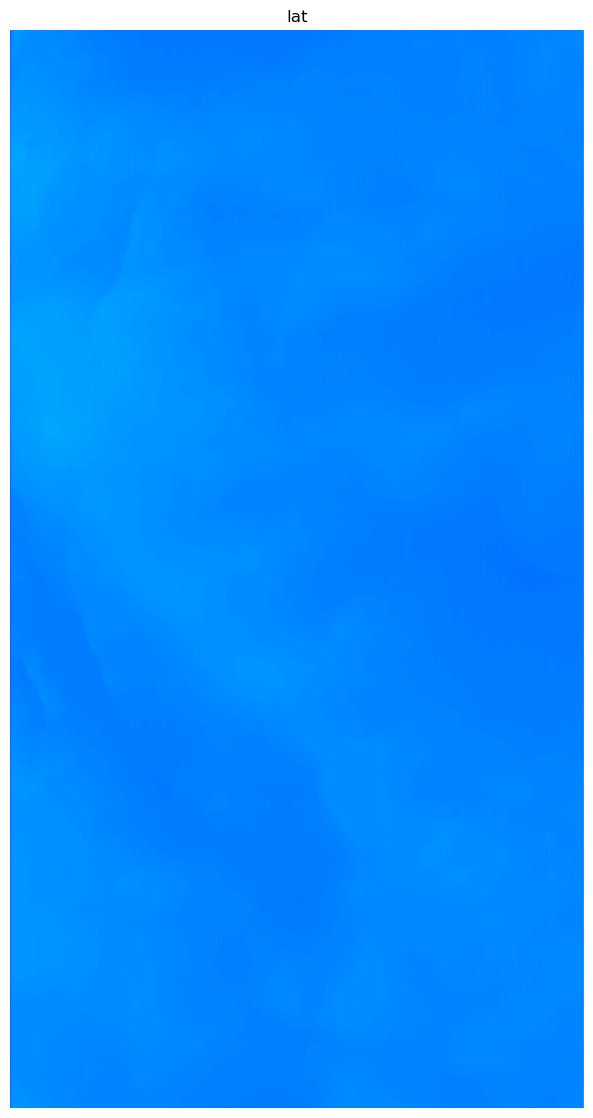

In [41]:
fig = plt.figure(figsize=(10, 14))

ax = fig.add_subplot(1,1,1)
ax.imshow(lat, cmap = 'jet')
ax.set_title("lat")
ax.set_axis_off()

In [21]:
# plot amplitude and wrapped interferogram

w_int = '/Users/jtarrico/sierra_isce_multi/download/int/20200131T1903_20200212T2211/20200131T1903_20200212T2211.int.vrt'
ds = gdal.Open(w_int, gdal.GA_ReadOnly)
igram = ds.GetRasterBand(1).ReadAsArray()
ds = None

In [ ]:
fig = plt.figure(figsize=(10, 14))

ax = fig.add_subplot(1,2,1)
ax.imshow(np.abs(igram), vmin = 0, vmax = .3, cmap = 'gray')
ax.set_title("Magnitude")
ax.set_axis_off()

ax = fig.add_subplot(1,2,2)
ax.imshow(np.angle(igram), cmap = 'jet', vmax = 3.14, vmin = -3.14)
ax.set_title("Phase")
ax.set_axis_off()

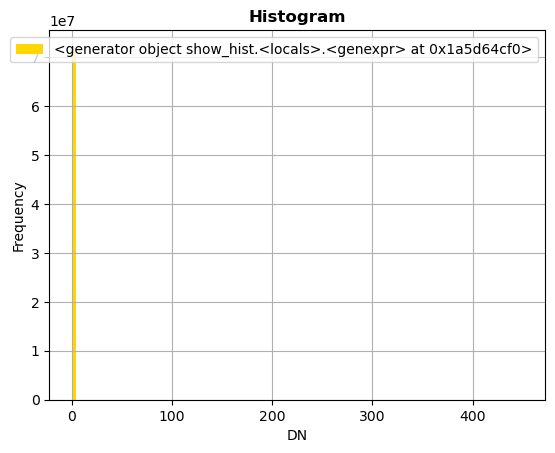

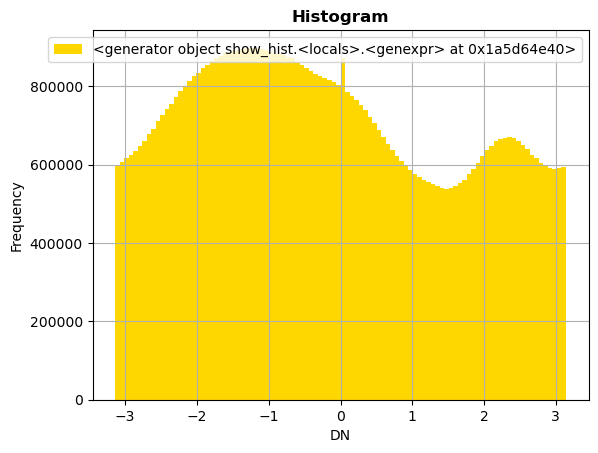

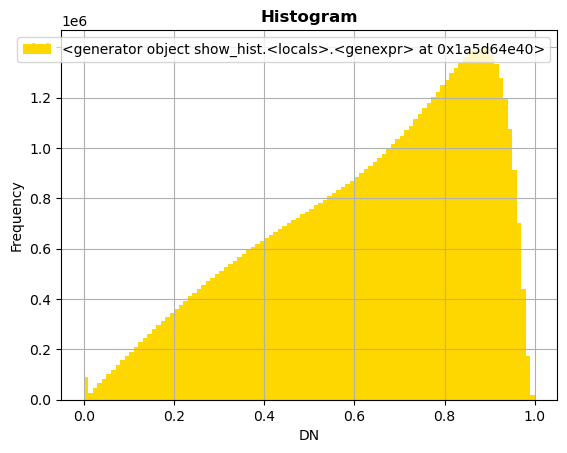

In [5]:
show_hist(np.abs(igram), bins = 100)
show_hist(np.angle(igram), bins = 100)
show_hist(coh, bins = 100)